# Chuẩn bị dữ liệu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


In [2]:
# Đọc dữ liệu
df = pd.read_csv('AEP_hourly.csv')

# Chuẩn hoá Datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime')
df = df.set_index('Datetime')

print(df.info())
print(df.head().to_markdown())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB
None
| Datetime            |   AEP_MW |
|:--------------------|---------:|
| 2004-10-01 01:00:00 |    12379 |
| 2004-10-01 02:00:00 |    11935 |
| 2004-10-01 03:00:00 |    11692 |
| 2004-10-01 04:00:00 |    11597 |
| 2004-10-01 05:00:00 |    11681 |


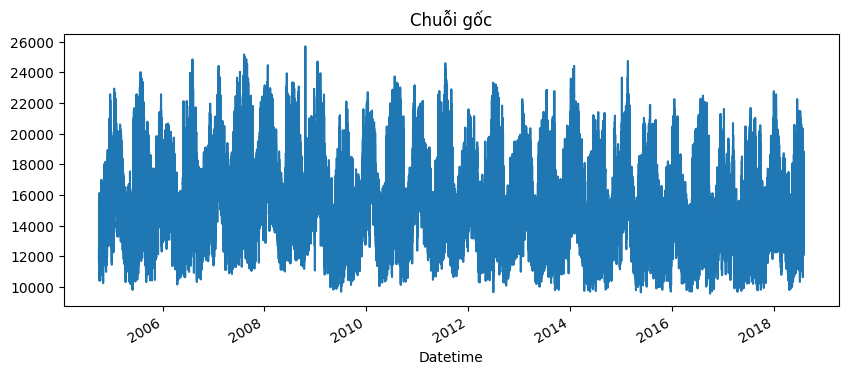

In [3]:
# Trực quan hoá chuỗi gốc
df['AEP_MW'].plot(figsize=(10, 4), title='Chuỗi gốc')
plt.show()

# Tạo lag features (Supervised Learning) 

In [4]:
def create_lag(df, p_lags):
    df_n = df.copy()
    for i in range(1, p_lags + 1):
        # Sử dụng hàm shift(i) để lấy giá trị quá khứ thứ i
        df_n[f'lag_{i}'] = df_n['AEP_MW'].shift(i)
    return df_n

In [5]:
p = 24 # sử dụng 24 giờ trước để dự báo
df_with_lags = create_lag(df, p)

# Loại bỏ các hàng có giá trị NaN do quá trình dịch chuyển
df_with_lags = df_with_lags.dropna()

# Chia X-y

In [6]:
# X là các cột đặc trưng trễ, y là giá trị mục tiêu cần dự báo
features = [f'lag_{i}' for i in range(1, p+ 1)]
target = 'AEP_MW'

X = df_with_lags[features]
y = df_with_lags[target]

# Chia train / test theo thời gian 

In [7]:
split = int(len(df_with_lags) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# XGBoost

In [8]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


# Dự đoán và đánh giá


In [9]:
y_pred = model.predict(X_test)

#Tính toán MAE MSE MAPE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")



MAE : 169.82
RMSE: 225.80
MAPE: 1.18%


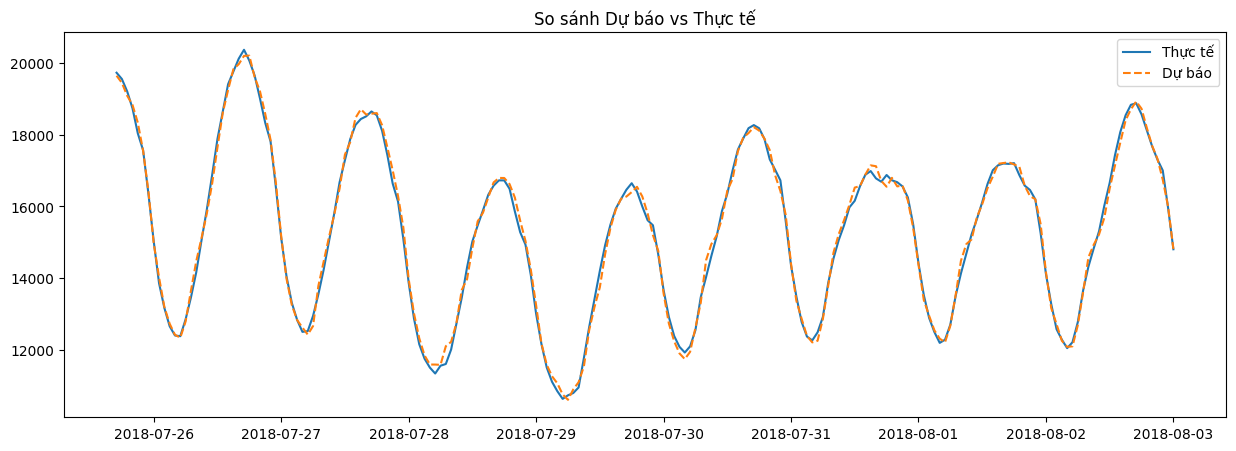

In [10]:
# Trực quan hóa kết quả dự báo so với thực tế (lấy 200 giờ cuối)
plt.figure(figsize=(15, 5))
plt.plot(y_test.index[-200:], y_test.values[-200:], label='Thực tế')
plt.plot(y_test.index[-200:], y_pred[-200:], label='Dự báo', linestyle='--')
plt.legend()
plt.title('So sánh Dự báo vs Thực tế')
plt.show()

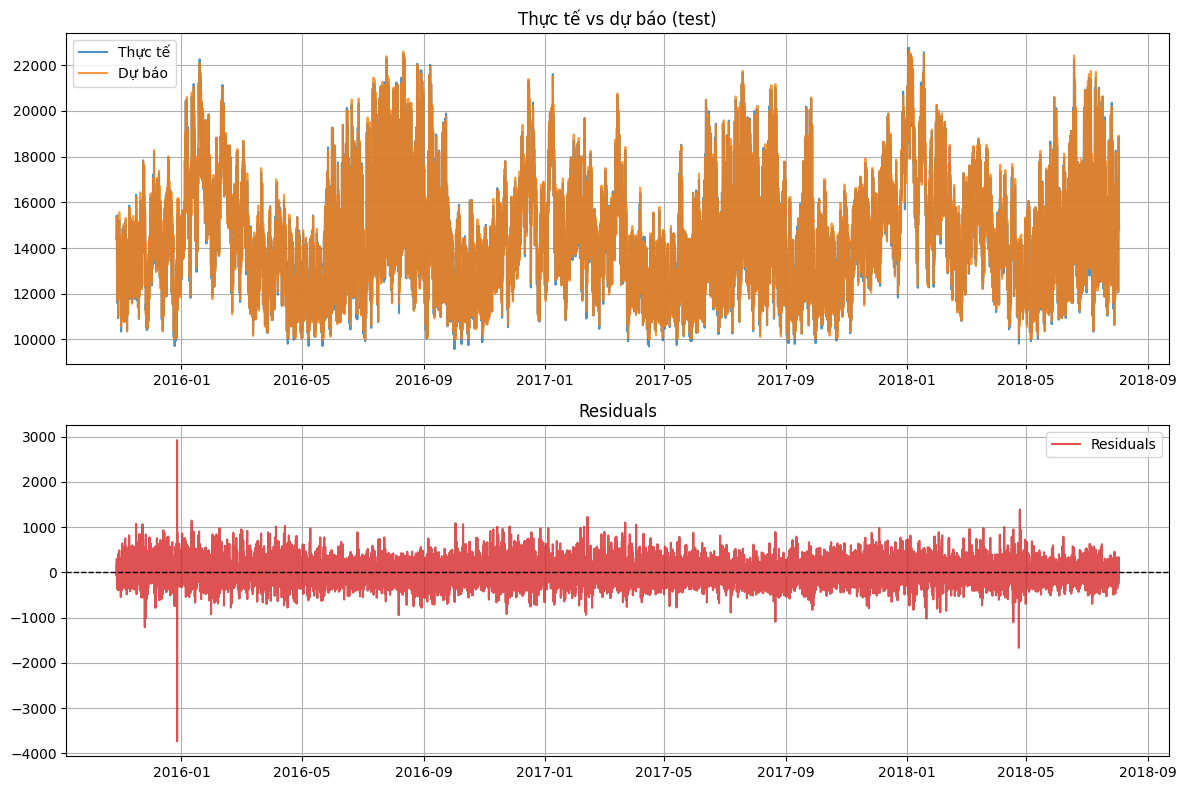

In [11]:
# So sánh thực tế vs dự báo (tập test) và residuals
test_pred_df = pd.DataFrame({
    "actual": y_test,
    "pred": y_pred
})
residuals = test_pred_df["actual"] - test_pred_df["pred"]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
axes[0].plot(test_pred_df.index, test_pred_df["actual"], label="Thực tế", alpha=0.8)
axes[0].plot(test_pred_df.index, test_pred_df["pred"], label="Dự báo", alpha=0.8)
axes[0].set_title("Thực tế vs dự báo (test)")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(residuals.index, residuals.values, label="Residuals", color="tab:red", alpha=0.8)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Residuals")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

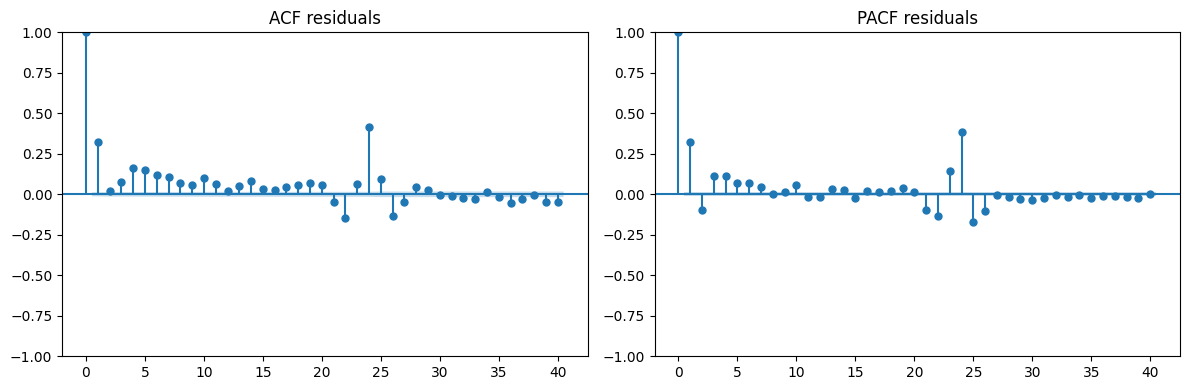

In [12]:
# ACF và PACF của residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

resid_clean = residuals.dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(resid_clean, lags=40, ax=axes[0])
axes[0].set_title("ACF residuals")
plot_pacf(resid_clean, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF residuals")
plt.tight_layout()
plt.show()


# Phân tích feature importance để tìm hiểu lag nào ảnh hưởng mạnh nhất đến dự báo 

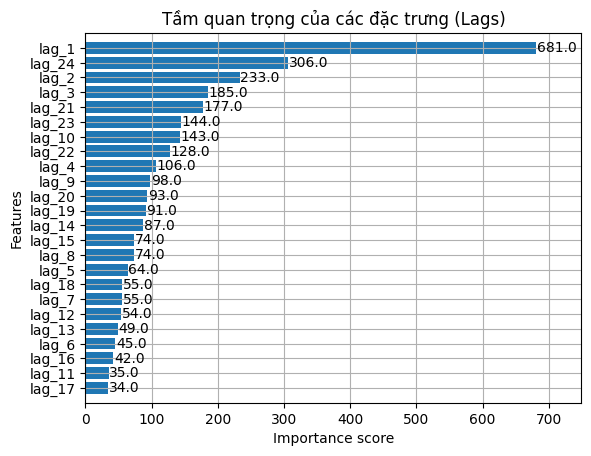

In [13]:
# Tìm hiểu lag nào ảnh hưởng mạnh nhất đến dự báo 
xgb.plot_importance(model, height=0.8)
plt.title('Tầm quan trọng của các đặc trưng (Lags)')
plt.show()

Lag 1 ($y_{t-1}$): Đây thường là biến quan trọng nhất. Nó đại diện cho giá trị tiêu thụ của ngay giờ trước đó, phản ánh tính liên tục của dữ liệu (nếu giờ trước cao thì giờ sau thường cũng cao)

Lag 24 ($y_{t-24}$): Đây là biến quan trọng thứ hai, đại diện cho giá trị tiêu thụ tại cùng thời điểm đó vào ngày hôm trước4444. Nó nắm bắt tính chu kỳ hàng ngày (ví dụ: 10 giờ sáng hôm nay sẽ có nhu cầu tương tự 10 giờ sáng hôm qua)

Lags lân cận (Lag 2, Lag 23, Lag 25): Các giá trị này cũng có tầm quan trọng nhất định vì chúng giúp mô hình ổn định hơn trước các biến động nhiễu tức thời6.

In [14]:
# Linear Regression để so sánh
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)

lin_mae = mean_absolute_error(y_test, lin_pred)
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_pred))
lin_mape = mean_absolute_percentage_error(y_test, lin_pred)

print(f"MAE : {lin_mae:.2f}")
print(f"RMSE: {lin_rmse:.2f}")
print(f"MAPE: {lin_mape:.2%}")

MAE : 147.85
RMSE: 203.31
MAPE: 1.02%


# Thêm rolling mean / rolling std

### Các chỉ số trung bình trượt giúp mô hình hiểu được xu hướng (trend) và độ biến động (volatility) trong một khoảng thời gian (ví dụ 24 giờ).

In [17]:
# Tạo đặc trưng rolling mean / std (shift trước để tránh leakage)
df_adv = df_with_lags.copy()
window_size = 24  # cửa sổ trượt 24h

df_adv['rolling_mean_24h'] = df_adv['AEP_MW'].shift(1).rolling(window=window_size).mean()
df_adv['rolling_std_24h'] = df_adv['AEP_MW'].shift(1).rolling(window=window_size).std()

# Dropna vì rolling/shift tạo NaN ở đầu
df_adv = df_adv.dropna()

# Cập nhật danh sách feature bao gồm cả lag và rolling
p = 24
features_adv = [f'lag_{i}' for i in range(1, p+1)] + ['rolling_mean_24h', 'rolling_std_24h']
X_adv = df_adv[features_adv]
y_adv = df_adv['AEP_MW']

# Chia train/test (giữ nguyên tỷ lệ 80/20)
split = int(len(df_adv) * 0.8)
X_train_adv, X_test_adv = X_adv.iloc[:split], X_adv.iloc[split:]
y_train_adv, y_test_adv = y_adv.iloc[:split], y_adv.iloc[split:]

print("Feature columns (advanced):", features_adv)
print("Shapes -> X_train_adv:", X_train_adv.shape, "X_test_adv:", X_test_adv.shape)


print("X_adv shape:", X_adv.shape)

Feature columns (advanced): ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean_24h', 'rolling_std_24h']
Shapes -> X_train_adv: (96980, 26) X_test_adv: (24245, 26)
X_adv shape: (121225, 26)


1. Phân tích các cột (Features) 
- Ta có 24 cột lag (từ lag_1 đến lag_24) + 2 cột rolling (mean và std) = 26 cột.
- Việc liệt kê đầy đủ tên cột như vậy giúp mô hình học được cả giá trị tức thời của quá khứ lẫn xu hướng tổng thể của cả ngày (rolling).

2. Phân tích số lượng dòng (Shapes)
- Tổng số dòng X_adv (121,225): Con số này khớp với logic dữ liệu. File gốc có khoảng 121,273 dòng.
    - Sau khi tạo lag 24, bạn mất 24 dòng đầu.
    - Sau khi tạo rolling 24h, bạn thường mất thêm một khoảng dòng nữa tùy vào cách tính.
    - Việc còn lại hơn 121 nghìn dòng là hoàn toàn chính xác.
- Tỷ lệ chia (80/20): * $96,980 / 121,225 = 80
    - 24,245 / 121,225 = 20
    - Việc chia theo iloc (thời gian) giúp đảm bảo tập Train luôn nằm trước tập Test, không vi phạm nguyên tắc dự báo chuỗi thời gian.

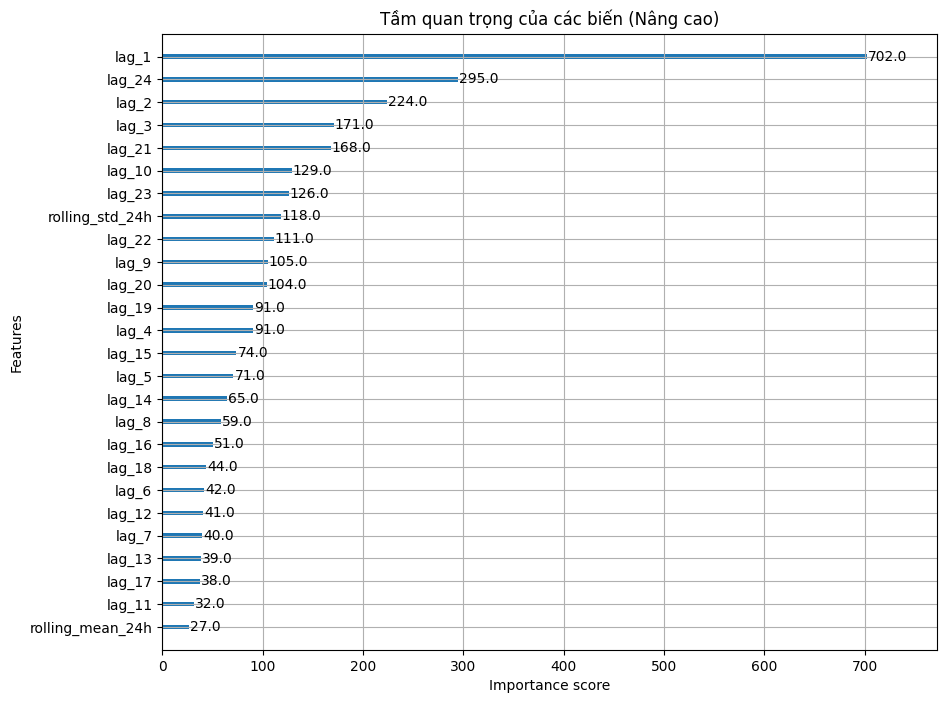

In [25]:
# Huấn luyện
model_adv = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model_adv.fit(X_train_adv, y_train_adv)

# Vẽ biểu đồ tầm quan trọng
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_adv, ax=plt.gca(), importance_type='weight')
plt.title("Tầm quan trọng của các biến (Nâng cao)")
plt.show()

# Dự báo Multi-step (Dự báo nhiều bước)
Thay vì chỉ dự báo $y_{t+1}$, ta muốn dự báo $y_{t+1}, y_{t+2}, \dots, y_{t+n}$. 

Có 2 cách chính:
- Recursive (Đệ quy): Dùng dự báo của $t+1$ làm đầu vào (lag) để dự báo $t+2$.
- Direct (Trực tiếp): Huấn luyện các mô hình riêng biệt cho từng bước nhảy.

In [28]:
# Recursive
from typing import Any


def multiforecast(model, last_row_features, n_steps, feature_names):
    current_features = last_row_features.copy()
    predictions = []

    for i in range(n_steps):
        # Chuyển đặc trưng hiện tại thành DataFrame để mô hình dự báo
        # (XGBoost cần đúng tên cột như lúc huấn luyện)
        feat_df = pd.DataFrame([current_features], columns = feature_names)

        # Dự báo giá trị bước tiếp theo
        pred = model.predict(feat_df)[0]
        predictions.append(pred)

        # Cập nhật vector đặc trưng cho bước tiếp theo
        # Tạo một dictionary để dễ thao tác với tên cột
        feat_dict = dict(zip(feature_names, current_features))

        # Dịch chuyển các lags: lag_24 = lag_23, ..., lag_2 = lag_1
        for j in range (24, 1, -1):
            feat_dict[f'lag_{j}'] = feat_dict[f'lag_{j -1}']

        # lag_1 của bước sau chính là kết quả dự báo vừa có
        feat_dict['lag_1'] = pred

        # Cập nhật các biến Rolling (Mean và Std) dựa trên các lags mới
        # Lấy danh sách các giá trị lag hiện tại (từ lag_1 đến lag_24)
        current_lags = [feat_dict[f'lag_{k}'] for k in range(1, 25)]
        
        if 'rolling_mean_24h' in feat_dict:
            feat_dict['rolling_mean_24h'] = np.mean(current_lags)
        if 'rolling_std_24h' in feat_dict:
            feat_dict['rolling_std_24h'] = np.std(current_lags)

        # Chuyển dictionary trở lại thành mảng theo đúng thứ tự cột
        current_features = np.array([feat_dict[f] for f in feature_names])
    return predictions


In [38]:
# 1. Chọn điểm bắt đầu: Dòng đầu tiên của tập test
start_index = 0 
h = 24 # Số bước dự báo

# Lấy vector đặc trưng tại điểm bắt đầu
start_feats = X_test_adv.iloc[start_index].values
start_time = X_test_adv.index[start_index]

# 2. Thực hiện dự báo đệ quy 24 bước
# Lưu ý: Hàm multiforecast bạn đã định nghĩa ở các cell trước
future_24h = multiforecast(model_adv, start_feats, h, features_adv)

# 3. Lấy giá trị thực tế tương ứng từ y_test_adv (24 giờ đầu tiên)
actual_24h = y_test_adv.iloc[start_index : start_index + h].values
time_axis = y_test_adv.index[start_index : start_index + h]

# 4. Tính toán các chỉ số sai số cho đoạn này
ms_mae = mean_absolute_error(actual_24h, future_24h)
ms_rmse = np.sqrt(mean_squared_error(actual_24h, future_24h))
ms_mape = mean_absolute_percentage_error(actual_24h, future_24h)

# 5. In bảng so sánh chi tiết
print(f"SO SÁNH MULTI-STEP 24 GIỜ (Bắt đầu từ: {start_time})")
print("-" * 75)
print(f"{'Thời gian':<20} | {'Thực tế (Actual)':<18} | {'Dự báo (Pred)':<15}")
print("-" * 75)
for i in range(h):
    print(f"{time_axis[i]} | {actual_24h[i]:>15.2f} MW | {future_24h[i]:>12.2f} MW")
print("-" * 75)
print(f"KẾT QUẢ ĐÁNH GIÁ ĐOẠN 24H NÀY:")
print(f"- MAE : {ms_mae:.2f} MW")
print(f"- RMSE: {ms_rmse:.2f} MW")
print(f"- MAPE: {ms_mape:.2%}")

SO SÁNH MULTI-STEP 24 GIỜ (Bắt đầu từ: 2015-10-27 20:00:00)
---------------------------------------------------------------------------
Thời gian            | Thực tế (Actual)   | Dự báo (Pred)  
---------------------------------------------------------------------------
2015-10-27 20:00:00 |        15422.00 MW |     15294.67 MW
2015-10-27 21:00:00 |        15225.00 MW |     15164.62 MW
2015-10-27 22:00:00 |        14549.00 MW |     14580.23 MW
2015-10-27 23:00:00 |        13744.00 MW |     13696.70 MW
2015-10-28 00:00:00 |        12869.00 MW |     12779.56 MW
2015-10-28 01:00:00 |        12295.00 MW |     12175.14 MW
2015-10-28 02:00:00 |        12031.00 MW |     11740.68 MW
2015-10-28 03:00:00 |        11753.00 MW |     11581.64 MW
2015-10-28 04:00:00 |        11606.00 MW |     11497.00 MW
2015-10-28 05:00:00 |        11870.00 MW |     11746.05 MW
2015-10-28 06:00:00 |        12490.00 MW |     12420.09 MW
2015-10-28 07:00:00 |        13757.00 MW |     13435.60 MW
2015-10-28 08:00:00 

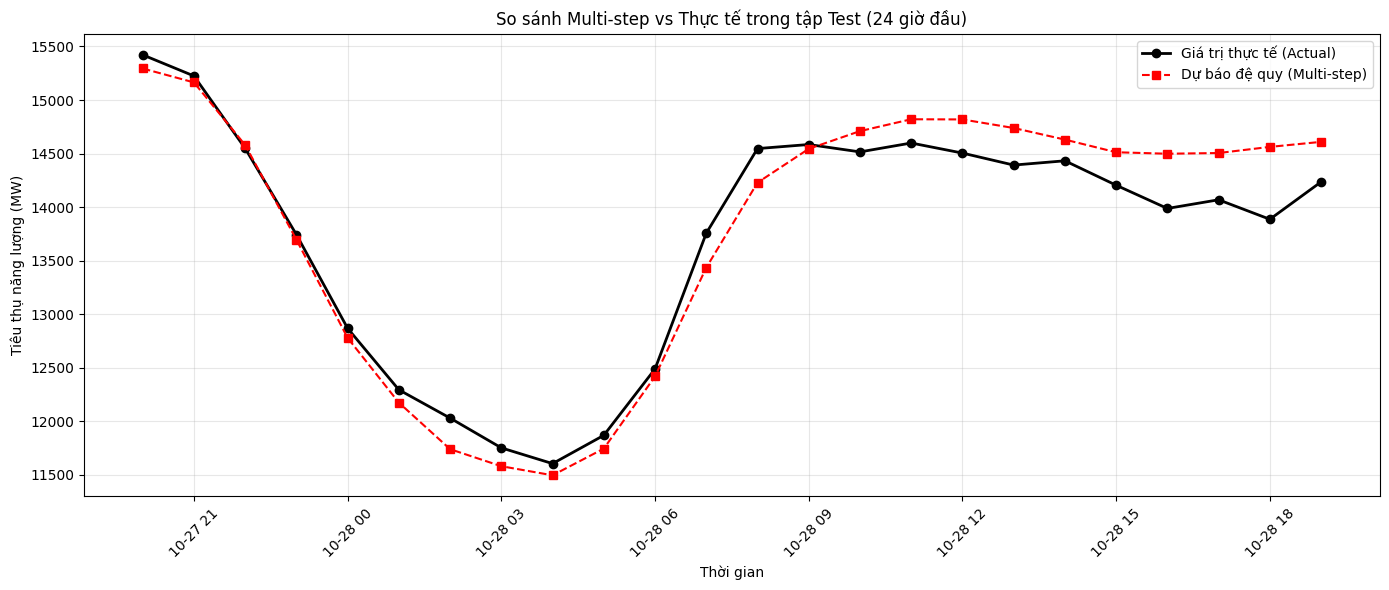

In [39]:
plt.figure(figsize=(14, 6))
plt.plot(time_axis, actual_24h, label='Giá trị thực tế (Actual)', marker='o', color='black', linewidth=2)
plt.plot(time_axis, future_24h, label='Dự báo đệ quy (Multi-step)', marker='s', color='red', linestyle='--')

plt.title(f'So sánh Multi-step vs Thực tế trong tập Test (24 giờ đầu)')
plt.xlabel('Thời gian')
plt.ylabel('Tiêu thụ năng lượng (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# 1. Tìm vị trí (index) đầu tiên trong tập Test có giờ là 01:00:00
# Cách này đảm bảo chúng ta dự báo từ đầu ngày
start_index = np.where(X_test_adv.index.hour == 1)[0][0] 

h = 24 # Dự báo đúng 24 bước (từ 1h sáng đến 12h đêm)

# Lấy vector đặc trưng tại mốc 1h sáng này
start_feats = X_test_adv.iloc[start_index].values
start_time = X_test_adv.index[start_index]

# 2. Thực hiện dự báo đệ quy
future_24h = multiforecast(model_adv, start_feats, h, features_adv)

# 3. Lấy giá trị thực tế và trục thời gian tương ứng
actual_24h = y_test_adv.iloc[start_index : start_index + h].values
time_axis = y_test_adv.index[start_index : start_index + h]

# 4. Tính toán sai số
ms_mae = mean_absolute_error(actual_24h, future_24h)
ms_rmse = np.sqrt(mean_squared_error(actual_24h, future_24h))
ms_mape = mean_absolute_percentage_error(actual_24h, future_24h)

# 5. In kết quả theo định dạng "Một ngày hoàn chỉnh"
print(f"BÁO CÁO DỰ BÁO CHI TIẾT NGÀY: {start_time.strftime('%d/%m/%Y')}")
print("-" * 75)
print(f"{'Giờ':<20} | {'Thực tế (Actual)':<18} | {'Dự báo (Pred)':<15}")
print("-" * 75)
for i in range(h):
    # Format lại hiển thị giờ cho đẹp
    hour_str = time_axis[i].strftime('%H:%M')
    print(f"{hour_str:<20} | {actual_24h[i]:>15.2f} MW | {future_24h[i]:>12.2f} MW")

print("-" * 75)
print(f"ĐÁNH GIÁ ĐỘ CHÍNH XÁC CỦA NGÀY NÀY:")
print(f"- MAE : {ms_mae:.2f} MW")
print(f"- RMSE: {ms_rmse:.2f} MW")
print(f"- MAPE: {ms_mape:.2%}")

BÁO CÁO DỰ BÁO CHI TIẾT NGÀY: 28/10/2015
---------------------------------------------------------------------------
Giờ                  | Thực tế (Actual)   | Dự báo (Pred)  
---------------------------------------------------------------------------
01:00                |        12295.00 MW |     12238.72 MW
02:00                |        12031.00 MW |     11812.55 MW
03:00                |        11753.00 MW |     11587.44 MW
04:00                |        11606.00 MW |     11507.03 MW
05:00                |        11870.00 MW |     11742.47 MW
06:00                |        12490.00 MW |     12383.24 MW
07:00                |        13757.00 MW |     13333.47 MW
08:00                |        14547.00 MW |     14129.49 MW
09:00                |        14585.00 MW |     14577.45 MW
10:00                |        14516.00 MW |     14775.37 MW
11:00                |        14599.00 MW |     14856.95 MW
12:00                |        14505.00 MW |     14828.25 MW
13:00                |     

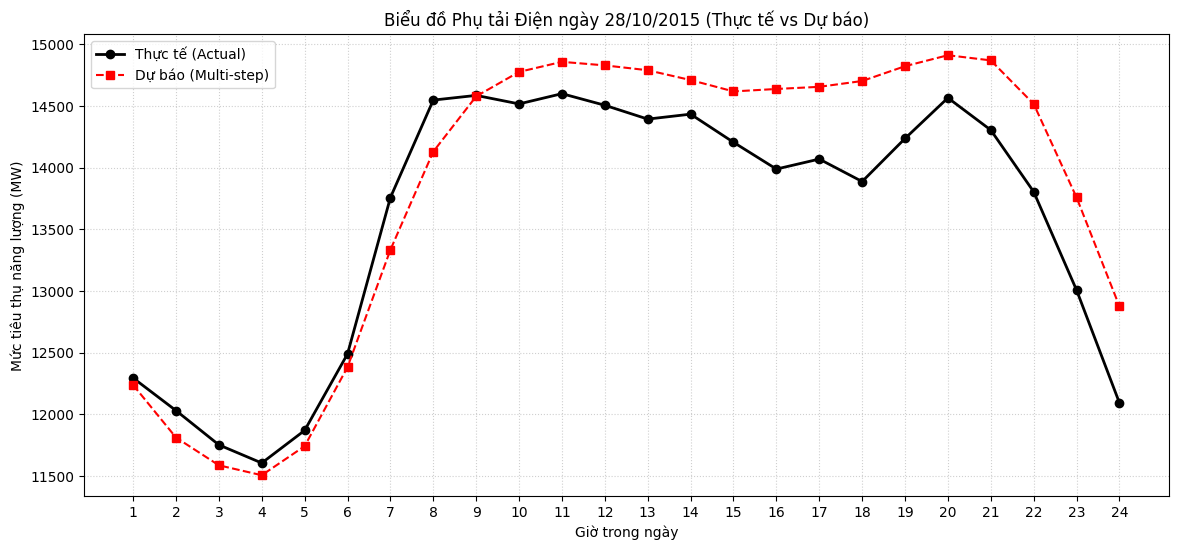

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(range(1, 25), actual_24h, label='Thực tế (Actual)', marker='o', color='black', linewidth=2)
plt.plot(range(1, 25), future_24h, label='Dự báo (Multi-step)', marker='s', color='red', linestyle='--')

# Làm đẹp trục X để hiện từ 1h đến 24h
plt.xticks(range(1, 25))
plt.title(f"Biểu đồ Phụ tải Điện ngày {start_time.strftime('%d/%m/%Y')} (Thực tế vs Dự báo)")
plt.xlabel('Giờ trong ngày')
plt.ylabel('Mức tiêu thụ năng lượng (MW)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Tune hyperparameter bằng TimeSeriesSplit
### Để hoàn thiện phần Tune hyperparameter bằng TimeSeriesSplit, bạn cần sử dụng kỹ thuật kiểm chứng chéo (Cross-validation) đặc thù cho chuỗi thời gian. Trong chuỗi thời gian, chúng ta không thể dùng K-Fold thông thường vì nó sẽ tráo trộn thứ tự thời gian, dẫn đến việc dùng dữ liệu tương lai để dự báo quá khứ (Data Leakage).

In [42]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# 1. Khởi tạo TimeSeriesSplit (thường chia 3-5 fold)
tscv = TimeSeriesSplit(n_splits=5)

# 2. Định nghĩa mô hình XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 3. Thiết lập lưới tham số (Parameter Grid)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# 4. Cấu hình GridSearchCV với cv=tscv
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error', # Tối ưu hóa dựa trên MAE
    verbose=1,
    n_jobs=-1 # Sử dụng tối đa các nhân CPU để chạy nhanh hơn
)

# 5. Tiến hành tìm kiếm trên tập Train (X_train_adv)
print("Đang tìm kiếm tham số tối ưu (có thể mất vài phút)...")
grid_search.fit(X_train_adv, y_train_adv)

# 6. Lấy kết quả tốt nhất
print("-" * 30)
print(f"Tham số tốt nhất tìm được: {grid_search.best_params_}")
print(f"MAE tốt nhất trên Cross-validation: {-grid_search.best_score_:.2f}")

# 7. Sử dụng mô hình tốt nhất để dự báo trên tập Test
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_adv)

# 8. Đánh giá lại trên tập Test
tuned_mae = mean_absolute_error(y_test_adv, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test_adv, y_pred_tuned))
tuned_mape = mean_absolute_percentage_error(y_test_adv, y_pred_tuned)

print("-" * 30)
print("KẾT QUẢ SAU KHI TUNE HYPERPARAMETER:")
print(f"MAE  : {tuned_mae:.2f}")
print(f"RMSE : {tuned_rmse:.2f}")
print(f"MAPE : {tuned_mape:.2%}")

Đang tìm kiếm tham số tối ưu (có thể mất vài phút)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
------------------------------
Tham số tốt nhất tìm được: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
MAE tốt nhất trên Cross-validation: 152.62
------------------------------
KẾT QUẢ SAU KHI TUNE HYPERPARAMETER:
MAE  : 140.70
RMSE : 191.12
MAPE : 0.97%


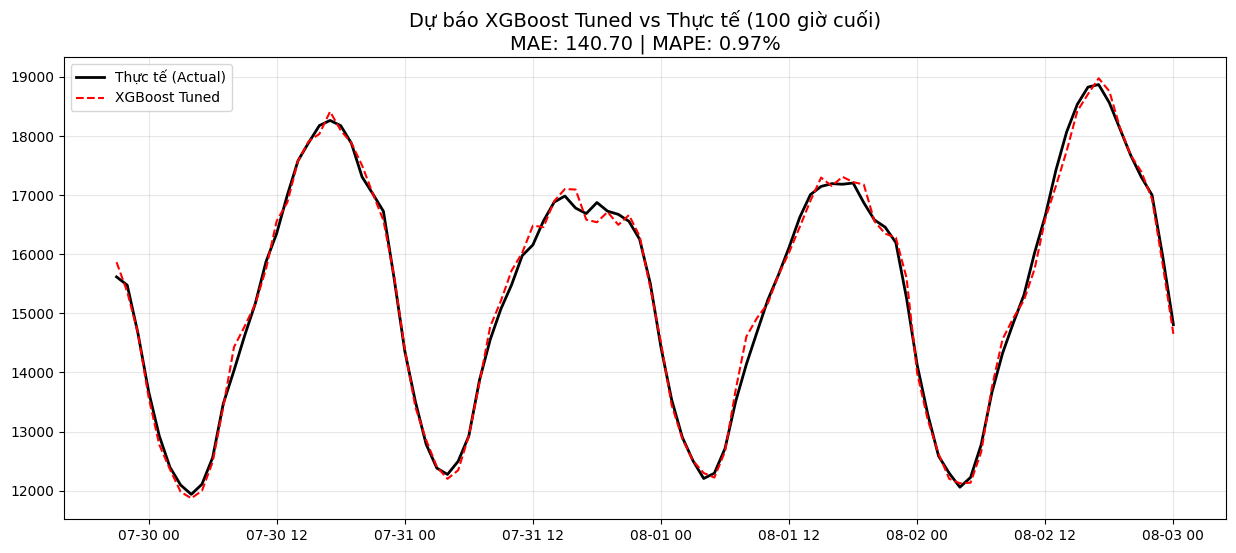

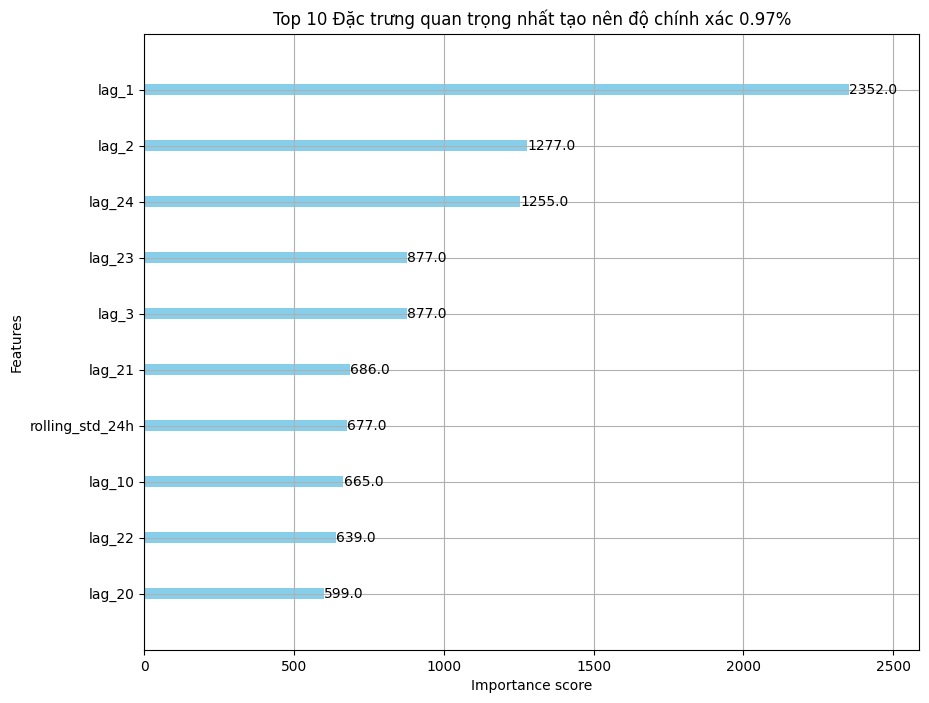

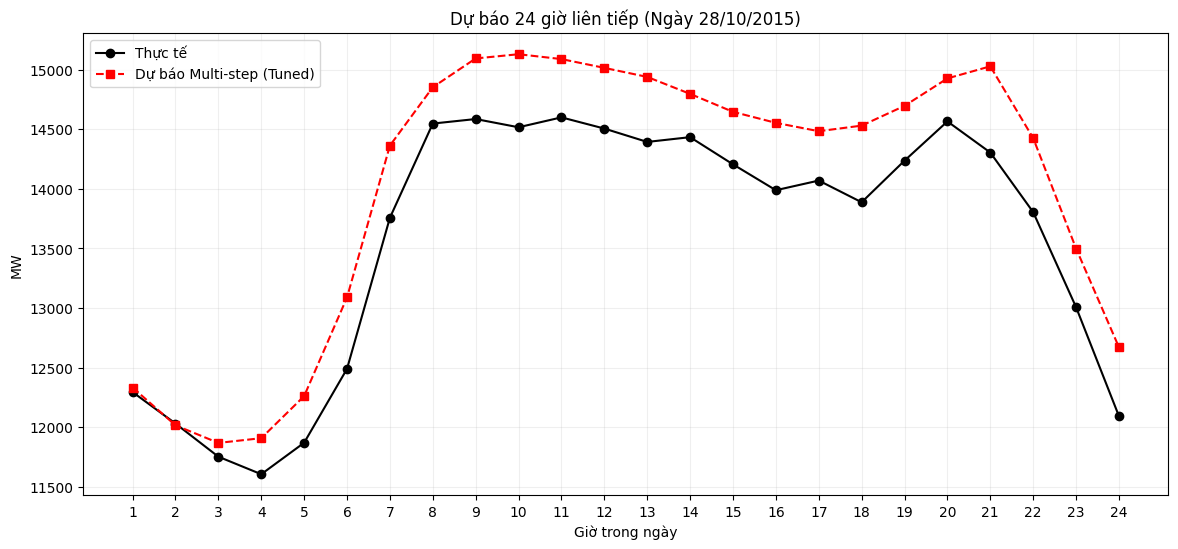

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Khởi tạo mô hình với bộ tham số tối ưu bạn vừa tìm được
best_xgb = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=7,
    n_estimators=150,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42
)

# 2. Huấn luyện lại trên toàn bộ tập Train Advanced
best_xgb.fit(X_train_adv, y_train_adv)

# 3. Dự báo tập test để lấy kết quả trực quan
y_pred_final = best_xgb.predict(X_test_adv)

# --- TRỰC QUAN HÓA ---

# Biểu đồ 1: So sánh Thực tế vs Dự báo (100 giờ cuối tập Test)
plt.figure(figsize=(15, 6))
plt.plot(y_test_adv.index[-100:], y_test_adv.values[-100:], label='Thực tế (Actual)', color='black', linewidth=2)
plt.plot(y_test_adv.index[-100:], y_pred_final[-100:], label='XGBoost Tuned', color='red', linestyle='--')
plt.title(f'Dự báo XGBoost Tuned vs Thực tế (100 giờ cuối)\nMAE: 140.70 | MAPE: 0.97%', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Biểu đồ 2: Tầm quan trọng của các đặc trưng (Top 10)
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_xgb, max_num_features=10, importance_type='weight', ax=plt.gca(), color='skyblue')
plt.title('Top 10 Đặc trưng quan trọng nhất tạo nên độ chính xác 0.97%')
plt.show()

# Biểu đồ 3: Dự báo Multi-step 24h hoàn chỉnh (Bắt đầu từ 1h sáng một ngày trong tập test)
# Tìm mốc 1h sáng
start_idx = np.where(X_test_adv.index.hour == 1)[0][0]
start_feats = X_test_adv.iloc[start_idx].values
time_axis = X_test_adv.index[start_idx : start_idx + 24]
actual_24h = y_test_adv.iloc[start_idx : start_idx + 24].values

# Thực hiện dự báo đệ quy với mô hình tốt nhất
future_24h_final = multiforecast(best_xgb, start_feats, 24, features_adv)

plt.figure(figsize=(14, 6))
plt.plot(range(1, 25), actual_24h, label='Thực tế', marker='o', color='black')
plt.plot(range(1, 25), future_24h_final, label='Dự báo Multi-step (Tuned)', marker='s', color='red', linestyle='--')
plt.xticks(range(1, 25))
plt.title(f"Dự báo 24 giờ liên tiếp (Ngày {time_axis[0].strftime('%d/%m/%Y')})")
plt.xlabel("Giờ trong ngày")
plt.ylabel("MW")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

# 1. Khởi tạo và huấn luyện mô hình Random Forest
# n_jobs=-1 giúp tận dụng tối đa CPU để chạy nhanh hơn
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_adv, y_train_adv)

# 2. Dự báo trên tập test
rf_pred = rf_model.predict(X_test_adv)

# 3. Tính toán các chỉ số
rf_mae = mean_absolute_error(y_test_adv, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test_adv, rf_pred))
rf_mape = mean_absolute_percentage_error(y_test_adv, rf_pred)

print("KẾT QUẢ MÔ HÌNH RANDOM FOREST:")
print(f"- MAE  : {rf_mae:.2f} MW")
print(f"- RMSE : {rf_rmse:.2f} MW")
print(f"- MAPE : {rf_mape:.2%}")

KẾT QUẢ MÔ HÌNH RANDOM FOREST:
- MAE  : 172.38 MW
- RMSE : 230.98 MW
- MAPE : 1.18%


In [46]:
# 1. Thực hiện dự báo Multi-step bằng Random Forest cho cùng một mốc thời gian (1h sáng)
# Sử dụng hàm multiforecast đã viết trước đó, chỉ thay model thành rf_model
future_24h_rf = multiforecast(rf_model, start_feats, h, features_adv)

# 2. Tính toán các chỉ số cho Random Forest Multi-step
rf_ms_mae = mean_absolute_error(actual_24h, future_24h_rf)
rf_ms_rmse = np.sqrt(mean_squared_error(actual_24h, future_24h_rf))
rf_ms_mape = mean_absolute_percentage_error(actual_24h, future_24h_rf)

print(f"ĐÁNH GIÁ MULTI-STEP RANDOM FOREST (Ngày {start_time.strftime('%d/%m/%Y')}):")
print(f"- MAE  : {rf_ms_mae:.2f} MW")
print(f"- RMSE : {rf_ms_rmse:.2f} MW")
print(f"- MAPE : {rf_ms_mape:.2%}")

ĐÁNH GIÁ MULTI-STEP RANDOM FOREST (Ngày 28/10/2015):
- MAE  : 419.55 MW
- RMSE : 490.50 MW
- MAPE : 3.11%


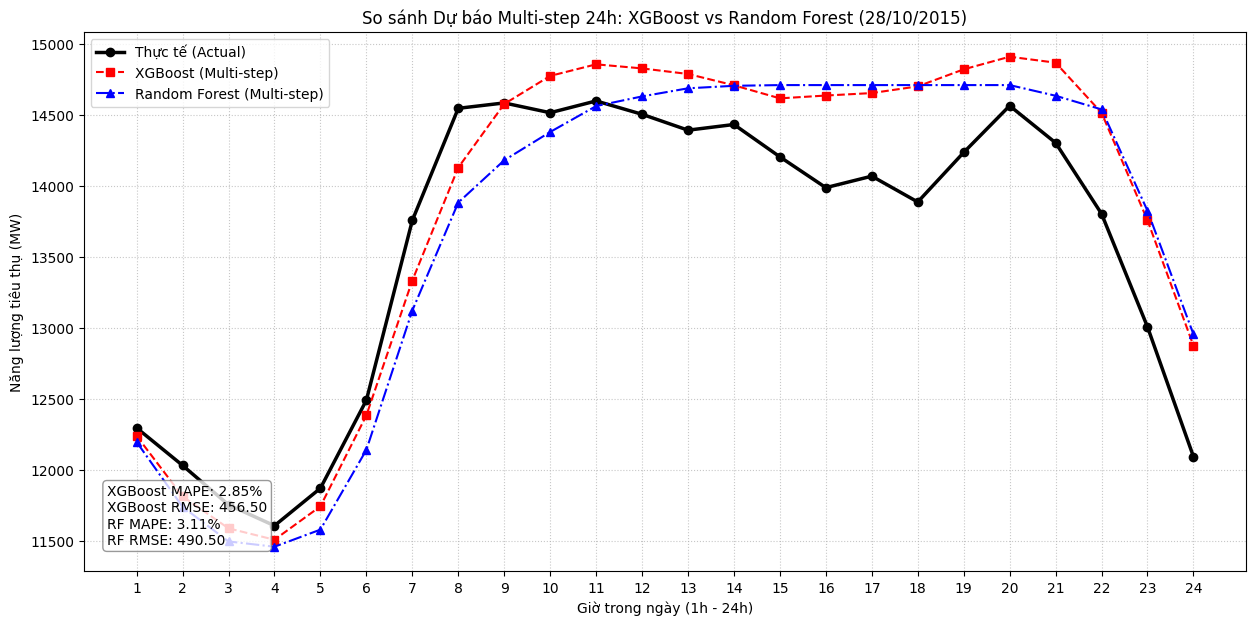

In [47]:
plt.figure(figsize=(15, 7))

# Đường giá trị thực tế
plt.plot(range(1, 25), actual_24h, label='Thực tế (Actual)', marker='o', color='black', linewidth=2.5)

# Đường dự báo của XGBoost (Tuned)
plt.plot(range(1, 25), future_24h, label='XGBoost (Multi-step)', marker='s', color='red', linestyle='--')

# Đường dự báo của Random Forest
plt.plot(range(1, 25), future_24h_rf, label='Random Forest (Multi-step)', marker='^', color='blue', linestyle='-.')

# Cấu hình biểu đồ
plt.title(f"So sánh Dự báo Multi-step 24h: XGBoost vs Random Forest ({start_time.strftime('%d/%m/%Y')})")
plt.xlabel('Giờ trong ngày (1h - 24h)')
plt.ylabel('Năng lượng tiêu thụ (MW)')
plt.xticks(range(1, 25))
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

# Ghi chú chỉ số lên biểu đồ để chuyên nghiệp hơn
text_info = (f"XGBoost MAPE: {ms_mape:.2%}\n"
             f"XGBoost RMSE: {ms_rmse:.2f}\n"
             f"RF MAPE: {rf_ms_mape:.2%}\n"
             f"RF RMSE: {rf_ms_rmse:.2f}")
plt.annotate(text_info, xy=(0.02, 0.05), xycoords='axes fraction', 
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))

plt.show()